## Using Siphon to query the NetCDF Subset Service for a timeseries

First we construct a TDSCatalog instance pointing to our dataset of interest, in
this case TDS' "Best" virtual dataset for the GFS global 0.5 degree collection of
GRIB files. We see this catalog contains a single dataset.

In [1]:
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_gfs.datasets

{'Best GFS Half Degree Forecast Time Series': <siphon.catalog.Dataset at 0x1084f4dd8>}

We pull out this dataset and look at the access urls.

In [2]:
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best'}

Note the `NetcdfSubset` entry, which we will use with our NCSS class.

In [3]:
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

We can then use the `ncss` object to create a new query object, which
facilitates asking for data from the server.

In [4]:
query = ncss.query()

We construct a query asking for data corresponding to latitude 40N and longitude 105W, for the next 7 days.
We also ask for NetCDF version 4 data, for the variable 'Temperature_isobaric', at the vertical level of 100000 Pa (approximately surface). This request will return all times in the range for a single point. Note the string representation of the query is a properly encoded query string.

In [5]:
from datetime import datetime, timedelta
now = datetime.utcnow()
query.lonlat_point(-105, 40).vertical_level(100000).time_range(now, now + timedelta(days=7))
query.variables('Temperature_isobaric').accept('netcdf')

var=Temperature_isobaric&time_end=2015-06-24T17%3A21%3A38.750638&time_start=2015-06-17T17%3A21%3A38.750638&longitude=-105&latitude=40&vertCoord=100000&accept=netcdf

We now request data from the server using this query. The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variables, as well as a few others (more metadata information)

In [6]:
data = ncss.get_data(query)
list(data.variables.keys())

['isobaric3',
 'Temperature_isobaric',
 'station_name',
 'station_description',
 'latitude',
 'longitude',
 'time']

We'll pull out the temperature  and time variables.

In [7]:
temp = data.variables['Temperature_isobaric']
time = data.variables['time']

The time values are in hours relative to the start of the entire model collection. Fortunately, the `netCDF4` module has a helper function to convert these numbers into Python `datetime` objects. We can see the first 5 element output by the function look reasonable.

In [8]:
from netCDF4 import num2date
time_vals = num2date(time[:].squeeze(), time.units)
time_vals[:5]

array([datetime.datetime(2015, 6, 17, 18, 0),
       datetime.datetime(2015, 6, 17, 21, 0),
       datetime.datetime(2015, 6, 18, 0, 0),
       datetime.datetime(2015, 6, 18, 3, 0),
       datetime.datetime(2015, 6, 18, 6, 0)], dtype=object)

Now we can plot these up using matplotlib, which has ready-made support for `datetime` objects.

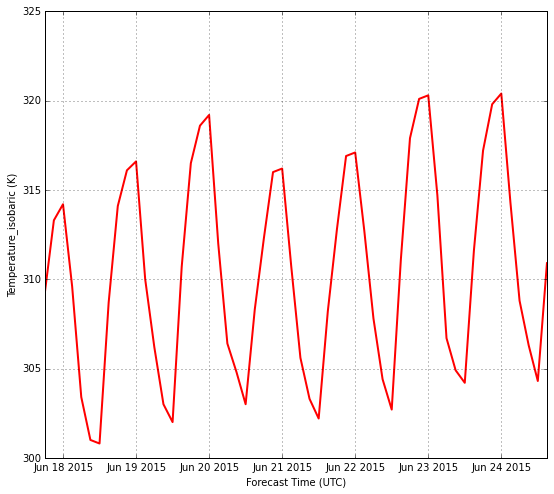

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(time_vals, temp[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel(temp.standard_name + ' (%s)' % temp.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.grid(True)